# Optimizing thresholds in fraud protection

### Bayesian Optimization applied to rule based decision automation on 2 risk hyper-parameters

This notebook shows you how to learn aspects of your decision logic to make better decisions. We assume that we prescrip a transaction authorization based on knowledge and risk scores. These risks score are assumed to be computed by a machine learning model or any statistical model. Goal of this notebokk is to explain the intrest in applying optimization to tune the 


## Contents 
This notebook contains the following main sections:

1. [Install HyperOpt.](#configure)
2. [Define a fraud detection model.](#datamodel)
3. [Define a logic to protect transactions against frauds](#prescript)
4. [Define a measurement of a transaction authorization.](#viewdecisions)
5. [Define a aggregate measurement function.](#viewdecisions)
6. [Define a decision objective function.](#viewdecisions)
7. [Call the optimum search.](#viewdecisions)
8. [Visualize the optimum search results.](#viewdecisions)
9. [Summary and next steps.](#summary)  

To get the most out of this notebook, you should have some familiarity with the Python programming language.

Resources:
* https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
* Notebook: https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb
* SEPA fraud scheme: https://www.ecb.europa.eu/pub/cardfraud/html/ecb.cardfraudreport201809.en.html#toc4

## 1 - Install hyperopt library and dependencies

In [1]:
%%capture
!pip install hyperopt
!pip install tqdm

Use a chosen version of tqdm for hyper opt

In [2]:
from faker import Faker

from pathlib import Path 

import json
import random 
import datetime

import os
import sys

import pandas as pd 
import numpy as np

import requests

import tqdm

import uuid

from pyspark.sql import SparkSession
from pyspark import SparkContext

from joblib import Parallel, delayed

print ("tqdm version : ", tqdm.__version__ )

tqdm version :  4.64.0


GLOBAL VARIBLES

In [3]:
SIMULATTE_BASE_DIR = os.environ['SIMULATTE_BASE_DIR'] #"/Users/tiemokodembele/Documents/internShip/simulatte-public" 
SIMULATTE_ONLINE_HOSTNAME = os.environ['SIMULATTE_ONLINE_HOSTNAME'] 
SIMULATTE_ANALYTIC_HOSTNAME = os.environ['SIMULATTE_ANALYTIC_HOSTNAME'] 

## 2 - Define a simple fraud data model

In [4]:
spark_session = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()

spark_context = SparkContext.getOrCreate()

############## DATA FROM REMOTE CSV FILE ################
def make_request(client, card, merchand, transaction, riskThresholds, request):
    client["id"] = str(uuid.uuid4())

    card["id"] = str(uuid.uuid4())
    card["risk"] = random.uniform(0, 1)
    card["client"] = client

    merchand["id"] = str(uuid.uuid4())
    merchand["risk"] = random.uniform(0, 1)

    transaction["id"] = str(uuid.uuid4())
    transaction["amount"] = random.randint(5000, 100000)
    transaction["card"] = card
    transaction["client"] = client
    transaction["merchand"] = merchand

    riskThresholds["card"] = random.uniform(0, 1)
    riskThresholds["merchand"] = random.uniform(0, 1)

    request["transaction"] = transaction
    request["riskThresholds"] = riskThresholds

    return json.dumps(request)

def get_data_from(data_sink_filepath, size, executor="JSE", file_format="PARQUET"):
    # check if data sink file already exists
    file = Path(data_sink_filepath)
    if file.exists():
        file = open(data_sink_filepath,"r+")
        file.truncate(0)
        file.close()

    # Models
    request = dict()
    card = dict()
    client = dict()
    merchand = dict()
    riskThresholds = dict()
    transaction = dict()

    requests = []

    if(executor=="JSE"):
        for counter in range(0, size):
            requests.append(make_request(client, card, merchand, transaction, riskThresholds, request))

        data = spark_context.textFile(data_sink_filepath)

    if(executor=="JSE_PARALLEL"):
        requests = Parallel(n_jobs=8)(
                        delayed(make_request)
                        (client, card, merchand, transaction, riskThresholds, request)
                        for row in tqdm(range(0,size))
                    )
    
    if(executor=="SPARK"):
        requests = spark_context.parallelize(range(0, size)) \
                .map(lambda counter : make_request(client, card, merchand, transaction, riskThresholds, request)) \
                .collect()

    if len(requests)!=0:
        with open(data_sink_filepath, 'a') as file:
            for request in requests:
                file.write(request)
                file.write('\n')

        if(file_format=="PARQUET"):
            data = spark_context.textFile(data_sink_filepath)
            data.saveAsTextFile(os.path.splitext(data_sink_filepath)[0])

            if Path(data_sink_filepath).exists():
                os.remove(data_sink_filepath)
        

size = 10
filesize = size
date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
if(size>999 and size<=999_999): filesize = str(size)[:-3]+"K"
if(size>999_999): filesize = str(size)[:-6]+"M"
data_filepath = f"{SIMULATTE_BASE_DIR}/data/ADS/paramsOptimization/detectFraudInCardTransactions/ads-22.0.1-detectFraudInCardTransactions-requests-{date_time}-{filesize}.json"
get_data_from(data_filepath, size, "JSE", "JSON")

DATA VIEW

In [5]:
######## GET DATA #########
dataSourcePathADS = data_filepath

inputData = []
with open(dataSourcePathADS) as file:
    while (line := file.readline().rstrip()):
        inputData.append(json.loads(line))

data = pd.json_normalize(inputData, max_level=1)
data.head(5)
#print("Data source uri : ",dataSourcePathADS)

,transaction.id,transaction.amount,transaction.card,transaction.client,transaction.merchand,riskThresholds.card,riskThresholds.merchand
0,b6127953-9a6a-46df-96bd-2ddeff442dfa,61825,"{'id': 'c8b3171a-aad0-443b-bb5c-99cf1c6d2812',...",{'id': 'd4e40736-ce40-4ef7-8cee-bc9d58bf15a9'},"{'id': 'dd934356-40bf-4c90-be0d-2862a98c84ef',...",0.338812,0.738119
1,4c45dae0-a899-4ccd-b956-702059c1c966,54445,"{'id': 'f68bafa2-898e-4a98-b42d-3c9f48e93708',...",{'id': '489c949c-1dfe-4622-9906-7cd696506022'},"{'id': '8b2b4d01-c42f-45a2-b18a-9ab5eaca5234',...",0.631591,0.014799
2,746a5fdd-5668-468d-ac55-8da4f39a4238,9544,"{'id': 'd593da5b-cafc-431a-a18d-4a6fe95eb293',...",{'id': '2a2046c7-3ca7-4154-862d-05a5ef4cc392'},"{'id': 'f577e732-372b-4016-a5ff-7bdd9bbb513e',...",0.230817,0.491489
3,d58513af-04c6-4048-bcd6-65ad6750cf6d,14704,"{'id': 'e35e61d3-be42-446c-b2fc-9a010c16c6ab',...",{'id': 'a16eaaa0-eaaf-4339-ab20-55a10434fa2e'},"{'id': '0f01a099-9dc4-4d17-b798-fea770dd3c13',...",0.393644,0.249924
4,daeb7535-6b72-4261-ac46-fdab791f0e1a,26390,"{'id': '78d8520e-f853-4f4f-b85c-09e185aed5ff',...",{'id': '5319d249-e8a2-4cab-8ad9-0998f9c0aa87'},"{'id': '3bd4762c-3e8f-4a06-9858-23af63df4715',...",0.677089,0.553116


In [ ]:
#To execute when using parquet files
dataSourcePathADS = os.path.splitext(data_filepath)[0]

## 3 - Define a fraud detection service

In [15]:
datasinkFolderPath = f"{SIMULATTE_BASE_DIR}/data/ADS/paramsOptimization/detectFraudInCardTransactions"
createSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulation/create"
deploymentSpaceId = "embedded"
decisionId = "_109077706/simulatte/fraud_detection/detectFraudDecisionService/1.6.0/detectFraudDecisionService-1.6.0.jar".replace("/", "%2F")
operation_name1 = "detect-fraud-in-card-transactions"
operation_name2 = "quantify-fraud-detection-business-efficiency"
adsEndpoint1 = f"https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/{deploymentSpaceId}/decisions/{decisionId}/operations/{operation_name1}/execute"
adsEndpoint2 = f"https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/{deploymentSpaceId}/decisions/{decisionId}/operations/{operation_name2}/execute"
token = "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI="
headers = {'Content-type': 'application/json'} 
BASIC_AUTH_USERNAME = "drsManager"
BASIC_AUTH_PASSWORD = "manager"

simulationObject = {
    "uid": 0,
    "name": "my simu",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSource": {
      "format": "JSON",
      "uri": dataSourcePathADS,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }



############## CREATE SIMULATION ################
try:    
    createSimulation = requests.post(createSimulationUrl, data = json.dumps(simulationObject), headers=headers)
    print("URL : ", createSimulationUrl)
    print("RESPONSE STATUS : ", createSimulation.status_code, "\n")
    if(createSimulation.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(createSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", createSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

URL :  http://simulation-service:8080/v1/simulation/create
RESPONSE STATUS :  200 

RESPONSE CONTENT :  {
     "uid": 65,
     "userUid": 0,
     "name": "my simu",
     "description": "string",
     "createDate": "2022-09-13T15:56:52.594+00:00",
     "lastUpdateDate": "2022-09-13T15:56:52.594+00:00",
     "trace": true,
     "dataSource": {
          "format": "JSON",
          "uri": "/home/jovyan/work/data/ADS/paramsOptimization/detectFraudInCardTransactions/ads-22.0.1-detectFraudInCardTransactions-requests-20220913_154511-10.json",
          "username": "string",
          "password": "string",
          "uid": 263
     },
     "dataSink": {
          "format": "JSON",
          "folderPath": "/home/jovyan/work/data/ADS/paramsOptimization/detectFraudInCardTransactions",
          "uri": null,
          "username": "string",
          "password": "string",
          "uid": 262
     },
     "decisionService": {
          "type": "ADS",
          "endPoint": "https://cpd-cp4a.apps.ads

## 4 - Define a fraud detection service metric function
This function measures the business performance of a fraud protection decision by the following cases:
<ul>
    <li>An authorized non fraudulent transaction rewards a fee.
    <li>An authorized but fraudulent transaction costs the amount of the transaction to be reimbursed to the client.
    <li>A blocked fraudulent transaction gets a zero result.
    <li>A blocked but non fraudulent transaction costs x% as an average of lost clients moving to other providers to make this transaction and possibly future ones.
</ul>

In [25]:
def generate_data_business_efficiency(data_to_read_uri, data_to_write_uri, executor="JSE", fromat="JSON") :
    file = Path(data_to_write_uri)
    if file.exists():
        file = open(data_to_write_uri,"r+")
        file.truncate(0)
        file.close()
    requests = []
    with open(data_to_read_uri) as file:
        while (line := file.readline().rstrip()):
            response_detect_fraud = json.loads(line)["response"] 
            response_detect_fraud.pop("__DecisionID__", None)
            response_detect_fraud["predictedFraud"] = response_detect_fraud.pop("detection")
            response_detect_fraud["actualFraud"] = bool(random.getrandbits(1))
            requests.append(response_detect_fraud)
    with open(data_to_write_uri, 'a') as file:
            for request in requests:
                file.write(json.dumps(request))
                file.write('\n')

#generate_data_business_efficiency(datasink_detect_fraud, data_filepath, "JSE", "JSON")
#print("Data in : ", data_filepath)

## 5 - Read the decision dataset

This report post processes the result of a simulation that wrote a dataset of automataed decisions in a data lake or a local file system. The first decisions found in the simulation dataset look like below:

## 5 - Define a fraud detection service metric aggregate

This function aggregates the business results for a set of decisions.

In [26]:
####### SIMULATION SPEC #############
def set_simulation_spec(name, trace, data_source_uri, datasink_folder, ds_endpoint):
    return {
    "uid": 0,
    "name": name,
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": trace,
    "dataSource": {
      "format": "JSON",
      "uri": data_source_uri,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasink_folder,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": ds_endpoint,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": "string",
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }


###### RUN SPEC #########
def set_run_spec(name, trace, datasink_folder, ds_endpoint, op_name, optim_params):
    return {
        "name": name,
        "description": "string",
        "createDate": "2022-05-18T23:31:19.828Z",
        "trace": trace,
        "dataSink": {
          "format": "JSON",
          "folderPath": datasink_folder,
          "username": "string",
          "password": "string"
        },
        "decisionService": {
          "type": "ADS",
          "endPoint": ds_endpoint,
          "operationName": op_name,
          "authType": "BASIC_AUTH",
          "username": BASIC_AUTH_USERNAME,
          "password": BASIC_AUTH_PASSWORD,
          "key": "string",
          "value": "string",
          "token": "string",
          "headerPrefix": "string"
        },
        "executor": {
            "type": "SPARK_STANDALONE",
            "mode": "REMOTE",
            "capability": "ODM",
            "uid": 0
        },
        "optimization": True,
        "optimizationParameters": optim_params
      }

In [27]:
########### START SIMULATION #############  
simulationUid1 = createSimulation.json()["uid"]
startSimulationUrl1 = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid1}/start/"
notebook_uri = f"{SIMULATTE_BASE_DIR}/notebooks/ADS/ads-vs-odm-loanvalidation-analytics.ipynb"
url_DSA1 = f"{SIMULATTE_BASE_DIR}/libs/ADS/DSA/fraud_detection_1.1.0.jar"
url_DSA2 = f"{SIMULATTE_BASE_DIR}/libs/ADS/DSA/fraud_detection_1.2.0.jar"
url_DSA5 = f"{SIMULATTE_BASE_DIR}/libs/ADS/DSA/fraud_detection_1.5.0.jar"
operation_name1 = "detect-fraud-in-card-transactions"
operation_name2 = "quantify-fraud-detection-business-efficiency"

def simulate(url, run_config):
    try:    
        startSimulation = requests.post(url, data = json.dumps(run_config), headers=headers)
        #print("STATUS CODE SIMULATE : ", startSimulation.status_code, "TOTO")
        return startSimulation 
    except requests.exceptions.RequestException as e:  
        raise SystemExit(e)


## 6 - Define a decision objective
Call the aggregate of business results with the hyper-parameter values.

In [28]:
def to_dataframe(data_path):
    outputData = []
    if os.path.exists(data_path):
        with open(data_path) as file:
            filesize = os.path.getsize(data_path)
            if filesize == 0:
                print("The file {} is empty".format(data_path))
            else:
                while (line := file.readline().rstrip()):
                    jsonLine = dict()
                    line_to_json = json.loads(line)
                    jsonLine["request"] = line_to_json["request"]
                    if(line_to_json["trace"]=="empty"): 
                        jsonLine["trace"] = "empty" 
                    else: 
                        jsonLine["trace"] = line_to_json["trace"]
                    jsonLine["response"] = line_to_json["response"]

                    outputData.append(jsonLine)

    return pd.json_normalize(outputData)

In [29]:
######## EVALUATE BUSINESS RESULT #########    
def evaluate_business_efficiency(card_risk, merchand_risk):
    """Objective function to minimize"""

    parametersList2 = [
            {
              "uid": 0,
              "name": "actualFraud",
              "value": "false",
              "type": "BOOLEAN",
              "description": "string"
            }
        ]
    run_config2 = set_run_spec("frauddetection", False, datasinkFolderPath, adsEndpoint2, operation_name2, parametersList2)
    
    param_value1 = dict()
    param_value1["card"] = card_risk
    param_value1["merchand"] = merchand_risk
    parametersList1 = [
        {
          "uid": 0,
          "name": "riskThresholds",
          "value": json.dumps(param_value1),
          "type": "JSON",
          "description": "string"
        }
    ]
    run_config1 = set_run_spec("frauddetection", False, datasinkFolderPath, adsEndpoint1, operation_name1, parametersList1)
    simulation_response = simulate(startSimulationUrl1, run_config1)
    if simulation_response.status_code==200 : 
        datasink_detect_fraud = simulation_response.json()["dataSink"]["uri"]
        data_source_business_uri = f"{SIMULATTE_BASE_DIR}/data/ADS/paramsOptimization/detectFraudInCardTransactions/ads-22.0.1-detectFraudInCardTransactions-requests-business-result-{filesize}.json"
        generate_data_business_efficiency(datasink_detect_fraud, data_source_business_uri, "JSE", "JSON")
            
        #create simulation to evaluate business result 
        datasink_folder = simulation_response.json()["dataSink"]["folderPath"]
        simulation_spec = set_simulation_spec("frauddetection", False, data_source_business_uri, datasink_folder, adsEndpoint1)
        create_simulation = requests.post(createSimulationUrl, data = json.dumps(simulation_spec), headers=headers)
        if create_simulation.status_code==200 :
            simulationUid2 = create_simulation.json()["uid"]
            startSimulationUrl2 = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid2}/start/"
            simulation_response = simulate(startSimulationUrl2, run_config2)
            
            #start simulation
            if simulation_response.status_code==200 :
                datasink_business_efficiency = simulation_response.json()["dataSink"]["uri"]
                datasink = to_dataframe(datasink_business_efficiency)
                get_transaction_business_cost = 'response.BusinessResult'
                return -datasink[get_transaction_business_cost].sum() #accumulator
            else:
                print("FAIL TO START SIMULATION ON 'BUSINESS RESULT'")
                if(simulation_response.status_code==500):
                    print("Check server side. PATH : ", simulation_response.json()["error"])
                else:
                    print("Check server side. ERROR : ", simulation_response.json()["message"])
        else:
            print("FAIL TO CREATE SIMULATION SPEC FOR 'BUSINESS RESULT'")
            if(simulation_response.status_code==500):
                print("Check server side. PATH : ", simulation_response.json()["error"])
            else:
                print("Check server side. ERROR : ", simulation_response.json()["message"])
    else:
        print("FAIL TO START SIMULATION ON 'DETECT FRAUD'")
        if(simulation_response.status_code==500):
            print("Check server side. PATH : ", simulation_response.json()["error"])
        else:
            print("Check server side. ERROR : ", simulation_response.json()["message"])
    
            
    return 0
        

In [30]:
def decisionObjective(threshold_space):
    """Objective function to minimize"""

    # Return the value of the decision aggregation
    return evaluate_business_efficiency(threshold_space['x1'], threshold_space['x2'])

## 7 - Define an optimum search
By using hyperopt library we define an optimum search over x trials. Optimization search algoritm takes the decision objective function and explores the hyper-parameter space in a limited number of trials to find the lower value.

In [31]:
from hyperopt import hp, tpe, fmin, Trials

import numpy as np
import pandas as pd

def searchOptimum ( space, function ):

    # Create the algorithm
    tpe_algo = tpe.suggest
    
    # Create a trials object
    tpe_trials = Trials()

    # Run 2000 evals with the tpe algorithm
    tpe_best = fmin(fn=function, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=10)

    print(tpe_best)
    
    #print(tpe_trials.idxs_vals[0])
    
    #print(tpe_trials.idxs_vals[0]['x1'])
    
    tpe_results = pd.DataFrame({
        'loss': [x['loss'] for x in tpe_trials.results], 
        'iteration': tpe_trials.idxs_vals[0]['x1'],
        'x1': tpe_trials.idxs_vals[1]['x1'],
        'x2': tpe_trials.idxs_vals[1]['x2']})
    
    tpe_results['rolling_average_x1'] = tpe_results['x1'].rolling(50).mean().fillna(method = 'bfill')
    tpe_results['rolling_average_x2'] = tpe_results['x2'].rolling(50).mean().fillna(method = 'bfill')
    tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
    
    tpe_results['card_risk'] = tpe_results['x1']
    tpe_results['merchand_risk'] = tpe_results['x2']
    tpe_results['business_result'] = - tpe_results['loss']
    
    return (tpe_best, tpe_results)
    

## 8 - Run the optimum search

We run the optimum search against the fraud decision objective function with a bi-dimensional hyper-parameter space. Search runs 2000 trials of the decision set to navigate to the lowest loss value.

In [38]:
# Create the domain space
#space = hp.uniform('x1', 0, 1)
#space = hp.choice('label', values)

x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
x2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space = {
    'x1': hp.uniform('x1', 0, 1),
    'x2': hp.uniform('x2', 0, 1)
}

(tpe_best, tpe_results) = searchOptimum(space, decisionObjective)

tpe_results.head(5)

100%|██████████| 10/10 [01:32<00:00,  9.25s/trial, best loss: 20.0]
{'x1': 0.8929903517466647, 'x2': 0.5255302132581486}


,loss,iteration,x1,x2,rolling_average_x1,rolling_average_x2,rolling_average_loss,card_risk,merchand_risk,business_result
0,80.0,0,0.284088,0.547965,NaN,NaN,NaN,0.284088,0.547965,-80.0
1,100.0,1,0.313045,0.081444,NaN,NaN,NaN,0.313045,0.081444,-100.0
2,100.0,2,0.403232,0.076673,NaN,NaN,NaN,0.403232,0.076673,-100.0
3,100.0,3,0.603817,0.069978,NaN,NaN,NaN,0.603817,0.069978,-100.0
4,20.0,4,0.892990,0.525530,NaN,NaN,NaN,0.892990,0.525530,-20.0


## 9 - Visualize the results

In [34]:
%%capture
!pip install brunel
import brunel

In [39]:
print(tpe_results)

    loss  iteration        x1        x2  rolling_average_x1  \
0   80.0          0  0.284088  0.547965                 NaN   
1  100.0          1  0.313045  0.081444                 NaN   
2  100.0          2  0.403232  0.076673                 NaN   
3  100.0          3  0.603817  0.069978                 NaN   
4   20.0          4  0.892990  0.525530                 NaN   
5  100.0          5  0.255189  0.324834                 NaN   
6   60.0          6  0.614084  0.616016                 NaN   
7  100.0          7  0.088129  0.327813                 NaN   
8   40.0          8  0.428144  0.816273                 NaN   
9  100.0          9  0.339042  0.009670                 NaN   

   rolling_average_x2  rolling_average_loss  card_risk  merchand_risk  \
0                 NaN                   NaN   0.284088       0.547965   
1                 NaN                   NaN   0.313045       0.081444   
2                 NaN                   NaN   0.403232       0.076673   
3             

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='x1', ylabel='x2'>

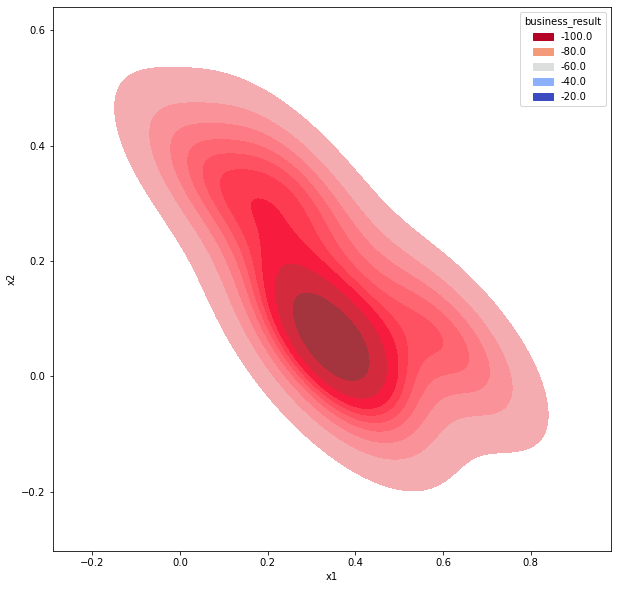

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#palette = sns.color_palette("crest")
#palette.reverse()

plt.figure(figsize=(10,10))
sns.kdeplot(
    data=tpe_results, x="x1", y="x2", hue="business_result", palette="coolwarm_r", fill=True,
)

In [41]:
%brunel data('tpe_results') x(card_risk) y(merchand_risk) color(loss:green-red) 

<IPython.core.display.Javascript object>

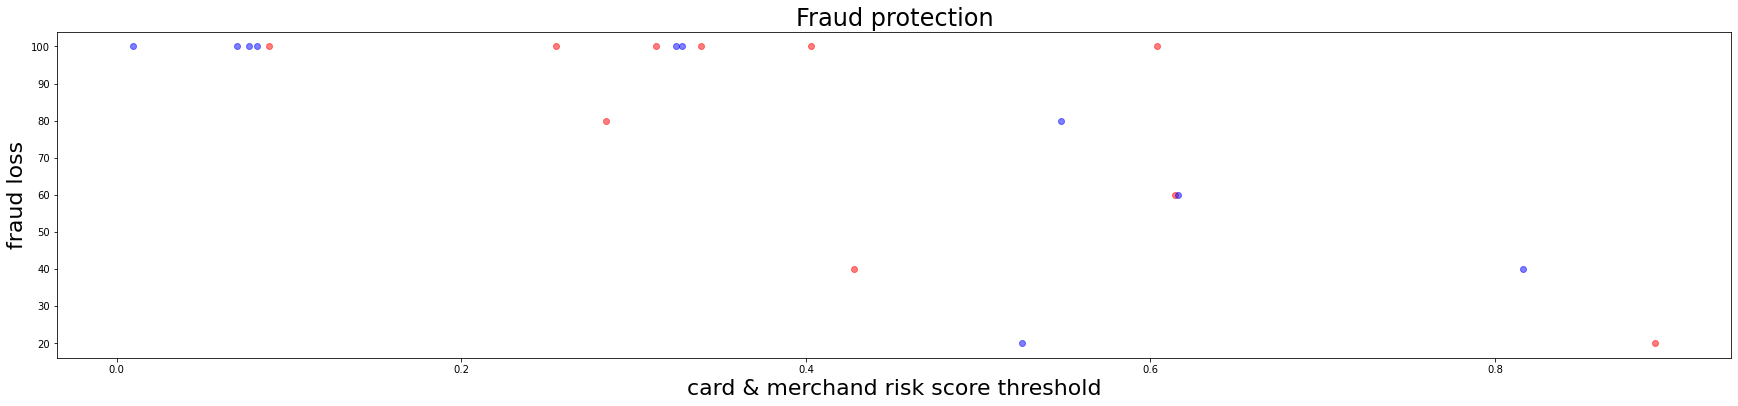

In [42]:
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize = (30, 6))
plt.plot(tpe_results['x1'], tpe_results['loss'],  'ro', alpha = 0.5);
plt.plot(tpe_results['x2'], tpe_results['loss'],  'bo', alpha = 0.5);

plt.xlabel('card & merchand risk score threshold', size = 22); 
plt.ylabel('fraud loss', size = 22); 
plt.title('Fraud protection', size = 24);

TypeError: unhashable type: 'dict'

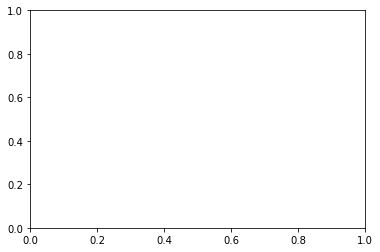

In [43]:

import seaborn as sns
from hyperopt.pyll.stochastic import sample

def displayDomainSpace ( space ):
    samples = []

    for _ in range(2000):
        samples.append(sample(space))
    
    plt.hist(samples, bins = 40, edgecolor = 'black'); 
    plt.xlabel('x1'); plt.ylabel('Frequency'); plt.title('Domain Space');
   

def displayTpeValues ( tpe_results ):
    plt.figure(figsize = (10, 8))
    plt.plot(tpe_results['iteration'], tpe_results['x1'],  'bo', alpha = 0.5);
    plt.xlabel('Iteration', size = 22); plt.ylabel('x1 value', size = 22); plt.title('TPE Sequence of Values', size = 24);

    plt.figure(figsize = (10, 8))
    plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
    plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');
    
def displayTpeHistogram ( tpe_results ): 
    plt.figure(figsize = (8, 6))
    plt.hist(tpe_results['x1'], bins = 50, edgecolor = 'k');
    plt.title('Histogram of TPE Values'); plt.xlabel('Value of x1'); plt.ylabel('Count');
    
displayDomainSpace ( space)
displayTpeHistogram ( tpe_results )
displayTpeValues ( tpe_results )